In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!nvidia-smi
import torch
use_gpu = torch.cuda.is_available()
use_gpu

Mon Mar  7 08:07:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
pip install --upgrade albumentations "opencv-python-headless<4.3"

In [ ]:
import os
import math
import copy
import traceback
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR, CyclicLR, ExponentialLR
import numpy as np
import pandas as pd
from torch import log, exp, max, abs
from IPython.display import clear_output
import cv2
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [ ]:
DATA_DIR = './data/CamVid/'

if not os.path.exists(DATA_DIR):
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')

In [ ]:
img_train_dir = os.path.join(DATA_DIR, 'train')
mask_train_dir = os.path.join(DATA_DIR, 'trainannot')

img_val_dir = os.path.join(DATA_DIR, 'val')
mask_val_dir = os.path.join(DATA_DIR, 'valannot')

img_test_dir = os.path.join(DATA_DIR, 'test')
mask_test_dir = os.path.join(DATA_DIR, 'testannot')

In [ ]:
class CustomDataset(Dataset):
    
    def __init__(self, imgs_dir, mask_dir, classes, transform=None, mode=None):
        self.img_names = os.listdir(imgs_dir)
        self.imgs = [os.path.join(imgs_dir, img_name) for img_name 
                                                      in self.img_names]
        self.masks = [os.path.join(mask_dir, img_name) for img_name 
                                                       in self.img_names]
        self.transform = transform
        self.mode = mode
        self.all_classes = ['sky', 'building', 'pole', 'road', 
                       'pavement', 'tree', 'signsymbol', 'fence', 
                       'car', 'pedestrian', 'bicyclist', 'unlabelled']
        self.classes_idx = [self.all_classes.index(c.lower()) for c in classes]

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx): 
        image = cv2.imread(self.imgs[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[idx], 0)
        
        my_classes_masks = [(mask == i) for i in self.classes_idx]
        mask = np.stack(my_classes_masks, axis=-1)

        image = np.array(image / 255., dtype='float32')
        mask = np.array(mask, dtype='float32')

        if self.transform:
            transformed = self.transform[self.mode](image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask'].permute(2,0,1)

        return image, mask

In [ ]:
batch_size = 8
classes = ['car']

data_transforms = {
    'train':  A.Compose([
        A.Resize(width=512, height=512),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(),
        A.PadIfNeeded(512, 512, always_apply=True, border_mode=0),
        A.RandomSizedCrop((512 - 100, 512 - 100), 512, 512),
        A.RandomBrightnessContrast(p=0.2),
        A.Blur(),
        ToTensorV2(p=1.0)
      ]),
      
    'val':  A.Compose([
        A.Resize(width=512, height=512),
        ToTensorV2(p=1.0)
      ])
}

train_ds = CustomDataset(img_train_dir, mask_train_dir, classes, 
                         transform=data_transforms, mode='train')
val_ds   = CustomDataset(img_val_dir, mask_val_dir, classes, 
                         transform=data_transforms, mode='val')

train_dl = DataLoader(train_ds, batch_size=batch_size, 
                      shuffle=True, num_workers=2, drop_last=True)
val_dl   = DataLoader(val_ds, batch_size=batch_size, 
                      shuffle=False, num_workers=2, drop_last=True)

In [ ]:
print(len(train_ds), len(val_ds))

367 101


In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True)
        )
        self.pool0 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(2,2), stride=(2,2)),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU()
        )  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3,3), stride=(1,1), padding=(1,1)),  
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=(3,3), stride=(1,1), padding=(1,1)),  
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=(2,2), stride=(2,2)),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU()
        ) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(3,3), stride=(1,1), padding=(1,1)), 
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(num_features=256), 
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(2,2), stride=(2,2)),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU()
        ) #64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=(3,3), stride=(1,1), padding=(1,1)), 
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3,3), stride=(1,1), padding=(1,1)), 
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(2,2), stride=(2,2)),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU()
        ) # 32 -> 16

        # bottleneck
        self.bottleneck_conv_enc = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=(3,3),stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 512, kernel_size=(3,3),stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True)
        )

        # decoder (upsampling)
        self.upsample0 = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=(2,2), stride=(2,2)),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU()
        ) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            #512 пробросилось из предыдщего симметричного слоя
            nn.Conv2d(1024, 512, kernel_size=(3,3),stride=(1,1), padding=(1,1)), 
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=(3,3), stride=(1,1), padding=(1,1)), 
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True)
        )
        self.upsample1 = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=(2,2), stride=(2,2)),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU()
        ) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=(3,3), stride=(1,1), padding=(1,1)), 
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=(3,3), stride=(1,1), padding=(1,1)), 
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True)
        )
        self.upsample2 = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=(2,2), stride=(2,2)),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU()
        )  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=(3,3), stride=(1,1), padding=(1,1)), 
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1)), 
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True)
        )
        self.upsample3 = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=(2,2), stride=(2,2)),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU()
        )  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1)), 
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1)), 
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=(1,1), stride=(1,1))
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        p0 = self.pool0(e0)
        e1 = self.enc_conv1(p0)
        p1 = self.pool1(e1)
        e2 = self.enc_conv2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc_conv3(p2)
        p3 = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv_enc(p3)

        # decoder
        u0 = self.upsample0(b)
        d0 = self.dec_conv0(torch.cat((u0,e3), dim=1))    
        u1 = self.upsample1(d0)
        d1 = self.dec_conv1(torch.cat((u1,e2), dim=1))
        u2 = self.upsample2(d1)
        d2 = self.dec_conv2(torch.cat((u2,e1), dim=1))
        u3 = self.upsample3(d2)
        d3 = self.dec_conv3(torch.cat((u3,e0), dim=1))  
        return d3

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte() 
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  
    union = (outputs | labels).float().sum((1, 2))        
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  
    
    return iou 

In [ ]:
def dice_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred)
    num = 2*(y_real*y_pred).sum((1,2,3))
    den = y_real.sum((1,2,3)) + y_pred.sum((1,2,3))
    SMOOTH = 1e-8
    res = 1 - ( (num+SMOOTH)/(den+SMOOTH) ).mean()
    return res 

In [ ]:
def plot_losses(history):
    plt.figure(figsize=(15, 9))
    plt.plot(history["train_loss"], label="train_loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

In [ ]:
def vizualize(epoch, epochs, train_avg_loss, val_avg_loss, loss_history, 
              images_val, masks_val, masks_hat):
    
    clear_output(wait=True)
    
    fig = plt.figure(figsize=(15, 10))
    fig.suptitle('Epoch [%d / %d] - (train loss, val loss): (%f, %f)' % 
                 (epoch+1, epochs, train_avg_loss, val_avg_loss))

    gs1 = gridspec.GridSpec(3, 4, left=0.0001, right=0.95, wspace=0.01)

    ax1 = fig.add_subplot(gs1[0, 0])
    ax1.imshow(np.rollaxis(images_val[0].numpy(), 0, 3), cmap='gray')
    ax1.set_title('Real')
    ax1.axis('off') 
    ax2 = fig.add_subplot(gs1[0, 1])
    ax2.imshow(masks_hat[0, 0], cmap='gray')
    ax2.set_title('Probs')
    ax2.axis('off') 
    ax3 = fig.add_subplot(gs1[0, 2])
    ax3.imshow(torch.sigmoid(masks_hat[0, 0]) > 0.5, cmap='gray')
    ax3.set_title('Output')
    ax3.axis('off') 
    ax4 = fig.add_subplot(gs1[0, 3])
    ax4.imshow(masks_val[0, 0], cmap='gray')
    ax4.set_title('Ground Truth')
    ax4.axis('off') 
    ax5 = fig.add_subplot(gs1[1, 0])
    ax5.imshow(np.rollaxis(images_val[1].numpy(), 0, 3), cmap='gray')
    ax5.set_title('Real')
    ax5.axis('off') 
    ax6 = fig.add_subplot(gs1[1, 1])
    ax6.imshow(masks_hat[1, 0], cmap='gray')
    ax6.set_title('Probs')
    ax6.axis('off') 
    ax7 = fig.add_subplot(gs1[1, 2])
    ax7.imshow(torch.sigmoid(masks_hat[1, 0]) > 0.5, cmap='gray')
    ax7.set_title('Output')
    ax7.axis('off')
    ax8 = fig.add_subplot(gs1[1, 3])
    ax8.imshow(masks_val[1, 0], cmap='gray')
    ax8.set_title('Ground Truth')
    ax8.axis('off')
    ax9 = fig.add_subplot(gs1[2, 0])
    ax9.imshow(np.rollaxis(images_val[2].numpy(), 0, 3), cmap='gray')
    ax9.set_title('Real')
    ax9.axis('off') 
    ax10 = fig.add_subplot(gs1[2, 1])
    ax10.imshow(masks_hat[2, 0], cmap='gray')
    ax10.set_title('Probs')
    ax10.axis('off') 
    ax11 = fig.add_subplot(gs1[2, 2])
    ax11.imshow(torch.sigmoid(masks_hat[2, 0]) > 0.5, cmap='gray')
    ax11.set_title('Output')
    ax11.axis('off') 
    ax12 = fig.add_subplot(gs1[2, 3])
    ax12.imshow(masks_val[2, 0], cmap='gray')
    ax12.set_title('Ground Truth')
    ax12.axis('off') 

    gs2 = gridspec.GridSpec(1, 1, left=1.01, right=2.0, hspace=0.01)
        
    ax13 = fig.add_subplot(gs2[:, :])
    ax13.plot(loss_history["train_loss"], label="train_loss")
    ax13.plot(loss_history["val_loss"], label="val_loss")
    ax13.legend(loc='best')
    ax13.set_xlabel("epochs")
    ax13.set_ylabel("loss")

    plt.show();

In [ ]:
def train(model, opt, loss_fn, epochs, scheduler, train_dl, val_dl):
    images_val, masks_val = next(iter(val_dl))

    loss_history = {"train_loss": [], "val_loss": []}

    best_val_avg_loss = float('inf')
    best_epoch = 0
    best_model = copy.deepcopy(model)

    for epoch in range(epochs):
        try:
            train_avg_loss, val_avg_loss = 0, 0
            
            model.train() 
            for images_batch, masks_batch in train_dl:
                
                images_batch = images_batch.to(device)
                masks_batch = masks_batch.to(device)

                opt.zero_grad()
                
                masks_pred = model(images_batch)
                loss = loss_fn(masks_batch, masks_pred) 
                
                loss.backward()  
                opt.step()  

                train_avg_loss += loss / len(train_dl)

            scheduler.step()

            model.eval()  
            with torch.no_grad():
                for images_val_batch, masks_val_batch in val_dl:
                    
                    images_val_batch = images_val_batch.to(device)
                    masks_val_batch = masks_val_batch.to(device)

                    masks_pred_val = model(images_val_batch)
                    val_loss = loss_fn(masks_val_batch, masks_pred_val)
                    
                    val_avg_loss += val_loss / len(val_dl)

            if val_avg_loss < best_val_avg_loss:
                best_epoch = epoch
                best_val_avg_loss = val_avg_loss
                best_model = copy.deepcopy(model)
            
            loss_history["train_loss"].append(
                train_avg_loss.detach().cpu().numpy()
            )
            loss_history["val_loss"].append(
                val_avg_loss.detach().cpu().numpy()
            )

            masks_hat = model(images_val.to(device)).detach().cpu() 
            vizualize(epoch, epochs, train_avg_loss, val_avg_loss, loss_history, 
                      images_val, masks_val, masks_hat)
        
        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем\n')
            break
        except Exception as ex:
            print('Ошибка: {}\n{}'.format(ex, traceback.format_exc()))
            break
    
    print(f'Best epoch loss on validation set: {best_val_avg_loss}')

    return loss_history, best_model, best_val_avg_loss

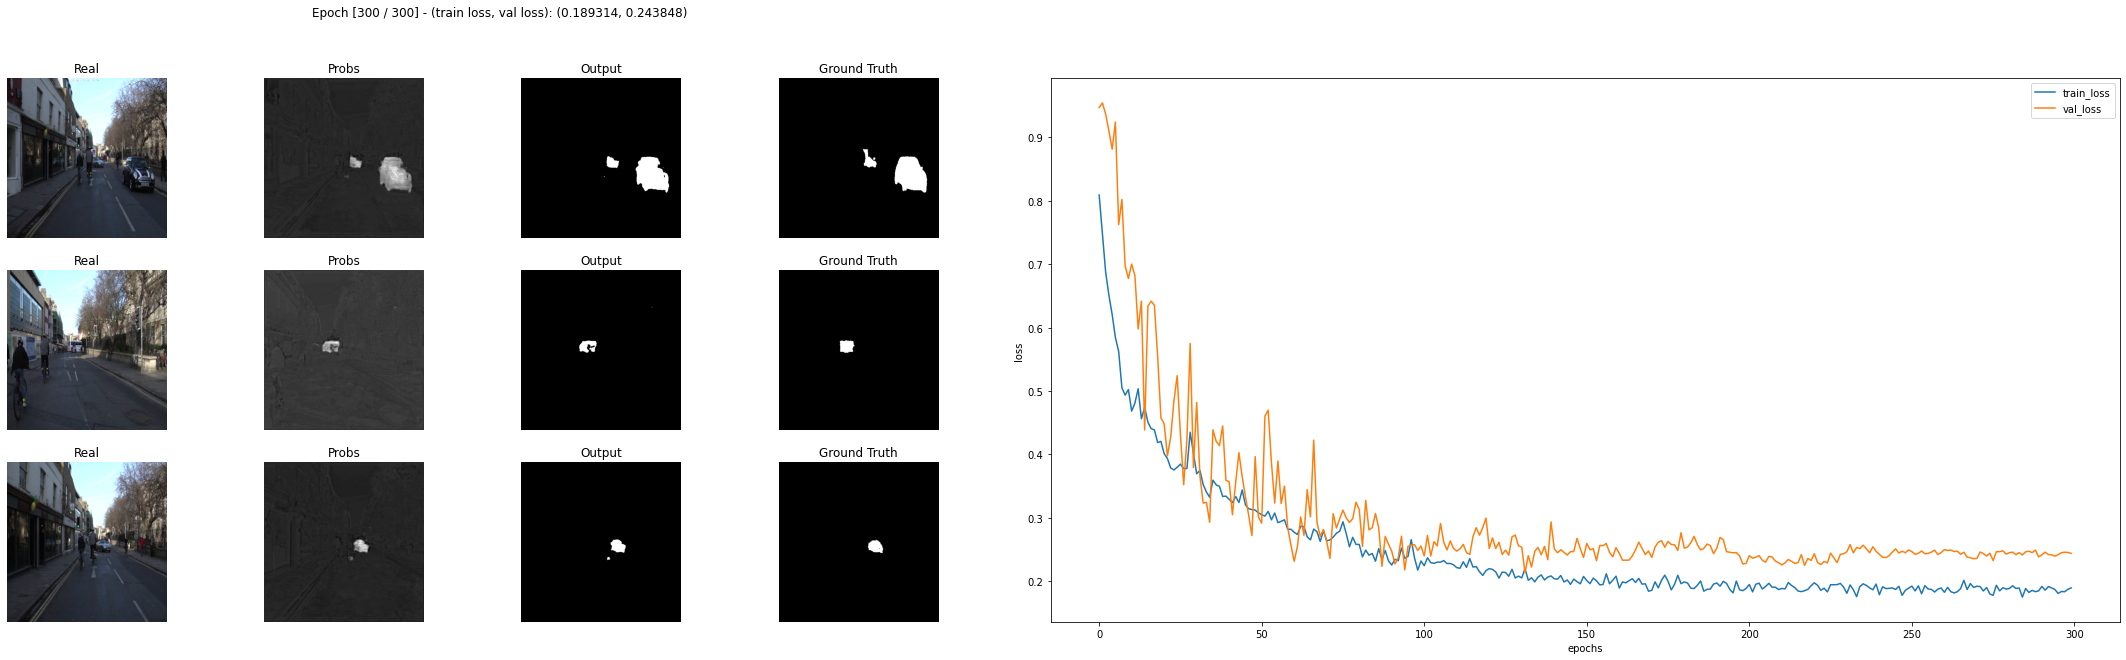

In [ ]:
max_epochs = 300

unet_model = UNet()
unet_model = unet_model.to(device)

opt = torch.optim.Adam(unet_model.parameters(), lr=8e-4)
scheduler = ExponentialLR(optimizer=opt, gamma=0.98)

history, best_model, best_val_avg_loss = train(unet_model, opt, dice_loss, max_epochs, scheduler, train_dl, val_dl)